# Leveraging N-Gram Part-of-Speech Tag Sequences for Automatic Genre Classification

This notebook contains the code for the paper "Leveraging N-Gram Part-of-Speech Tag Sequences for Automatic Genre Classification" by Isabel Arvelo. The paper submitted as a final project in the course DS 5780: Natural Language Processing at Vanderbilt University.

## Importing Libraries

In [1]:
# Importing General Purpose Libraries 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import json
from IPython.display import display, HTML 

# Importing Libraries for Statistical Analysis 
import statsmodels.api as sm
import scipy.stats as stats

# Importing Libraries for Modeling
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# Import spaCy
import spacy 

# Importing nltk because it is required for text cleaning package gutenberg_cleaner
import nltk

# Loading gutenberg_cleaner, a python package for cleaning Gutenberg books and dataset
# Author: Peyman Mohseni kiasari
from gutenberg_cleaner import simple_cleaner


In [2]:
# Setting Random Seed for Reproducibility - If you set a seed, every time you run the code, you will get the same output, but if your seed is different, you will get a different output
RANDOM_SEED = 77

## Importing Data 

I ran initially ran the analysis with a sample of 4,999 texts, but then wanted to use more data for the final iteration of this project which is why I am importing two different csv files. I ran the analysis with slight modifications the second time around, so to ensure reproducibility the processing on both of the original corpuses will be done separately until the actual model building. 

In [40]:
# Reading in the raw data
df_raw_1 = pd.read_csv('gutenberg_books_raw.csv')
df_raw_2 = pd.read_csv('gutenberg_books_raw_2.csv')

## Data Cleaning and Pre-Processing

In [41]:
# Filter out any texts that are in the top 5% of lengths
max_len = round(df_raw_1['TEXT'].str.len().quantile(0.95))
df_1 = df_raw_1[df_raw_1['TEXT'].str.len() < max_len]
max_len

1222769

In [42]:
# Filter out any texts that are in the top 5% of lengths
max_len = round(df_raw_2['TEXT'].str.len().quantile(0.95))
df_2 = df_raw_2[df_raw_2['TEXT'].str.len() < max_len]
max_len

958397

In [6]:
# Function to safely parse JSON
def safe_json_parse(str_json):
    try:
        return json.loads(str_json)
    except ValueError:
        return {}  # Return empty dict if parsing fails

In [45]:
df_1 = df_1.copy()
df_2 = df_2.copy()

# Apply the JSON parsing
df_1['parsed_metadata'] = df_1['METADATA'].apply(safe_json_parse)
df_2['parsed_metadata'] = df_2['METADATA'].apply(safe_json_parse)

# Extract 'subjects'
df_1['subjects'] = df_1['parsed_metadata'].apply(lambda x: x.get('subjects', ''))
df_2['subjects'] = df_2['parsed_metadata'].apply(lambda x: x.get('subjects', ''))

In [43]:
# Evaluate the most common subjects
df_1['subjects'].value_counts().head(10)

subjects
Fiction                                                                                                                                     52
French fiction -- Translations into English                                                                                                 48
Spain -- Social life and customs -- 16th century -- Fiction; Knights and knighthood -- Spain -- Fiction; Picaresque literature; Romances    43
Presidents -- United States -- Messages; United States -- Politics and government -- Sources                                                39
Poetry                                                                                                                                      35
Fiction; Short stories                                                                                                                      31
Quotations                                                                                                                           

In [155]:
# Evaluate the most common subjects
df_1['subjects'].value_counts().head(10)

subjects
Fiction                                                                                                                                     52
French fiction -- Translations into English                                                                                                 48
Spain -- Social life and customs -- 16th century -- Fiction; Knights and knighthood -- Spain -- Fiction; Picaresque literature; Romances    43
Presidents -- United States -- Messages; United States -- Politics and government -- Sources                                                39
Poetry                                                                                                                                      35
Fiction; Short stories                                                                                                                      31
Quotations                                                                                                                           

Using the common keywords related to genre in the subjects field such as "Fiction", "American poetry" etc., we can identify the genre of the text. This will be the target variable for the model. Each text can have multiple genres, but we are only interested in classification as fiction or non-fiction. Poetry will be excluded from the analysis.

The first time I ran the analysis for the first dataframe, I used slightly different keywords, which is why two set of key words for each corpus appear below. I kept this for reproducibility, but if you were to run this analysis on a different set of texts, it would be easier to only use one only set of key words.

In [48]:
# First Iteration Keywords 

# Fiction Keywords
df_1_fiction_keywords = [
    'adventure stories', 'detective and mystery stories', 'science fiction',
    'fantasy fiction', 'historical fiction', 'fairy tales', 'fables',
    'folklore', 'didactic fiction', 'tragedies', 'comedy fiction',
    'musical fiction', 'women-centered fiction', 'storytelling',
    'drama', 'legends', 'comedies', 'romance fiction', 'horror fiction',
    'war stories', 'crime fiction', 'fiction'
]


# Non-Fiction Keywords
df_1_non_fiction_keywords = [
    'sacred books',  'church', 'property', 'doctrines','apocryphal', 'speeches', 'compact', 
    'american essays', 'biography', 'description', 'methodology', 'politics and government', 
    'foreign relations','english language', 'government', 'art and science', 'photography',
    'criticism and interpretation', 'philosophy', 'spiritualism', 'study', 'social life and customs', 
    'correspondence', "address", "essays", "socialism", "essays", "english essays", "socialism", 
    "medicine", "sociology", "biology", "psychology", "anatomy", "dialogues", "finance", "cooking",
    "anecdotes", 'social problems'
]

# Poetry keywords 
df_1_poetry_keywords = ['poetry', 'epic poetry', 'sonnets', 'haiku', 'lyrical poetry']

In [ ]:
# Second Iteration Keywords

# Fiction Keywords
df_2_fiction_keywords = [
    'fiction', 'adventure stories', 'detective and mystery stories', 'fairy tales', 'fables',
    'folklore',  'tragedies',  'storytelling', 'drama', 'legends', 'comedies', 
    'war stories', "short stories", "christmas stories", "western stories"
]


# Non-Fiction Keywords
df_2_non_fiction_keywords = [
    'sacred books',  'church', 'property', 'doctrines','apocryphal', 'speeches', 'compact', 
    'american essays', 'biography', 'description', 'methodology', 'politics and government', 
    'foreign relations','english language', 'government', 'art and science', 'photography',
    'criticism and interpretation', 'philosophy', 'spiritualism', 'study', 'social life and customs', 
    'correspondence', "address", "essays", "socialism", "essays", "english essays", "socialism", 
    "medicine", "sociology", "biology", "psychology", "anatomy", "dialogues", "finance", "cooking",
    "anecdotes", 'social problems', "quotations", "autographs", "social problems", "sources", 
    "description and travel", "science", "periodicals", "world war"
]

# Poetry keywords 
df_2_poetry_keywords = ['poetry', 'sonnets', 'haiku']

In [50]:
# Function to categorize books
def categorize_book(subject, fiction_keywords, non_fiction_keywords, poetry_keywords):
    """   
    Categorize books based on the subject metadata

    Args:
    subject: str: the subject metadata of the book

    Returns:
    str: the category of the book
    """
    subject_lower = subject.lower()
    genres = []

    # Check for each genre
    if any(keyword in subject_lower for keyword in fiction_keywords):
        genres.append('Fiction')
    if any(keyword in subject_lower for keyword in non_fiction_keywords):
        genres.append('Non-Fiction')
    if any(keyword in subject_lower for keyword in poetry_keywords):
        genres.append('Poetry')

    # Determine category based on genres list
    if len(genres) > 1:
        # If the word fiction is in the genre - put it in Fiction if not put it in conflicting 
        if ' fiction' in subject_lower:
            return 'Fiction'
        elif 'poetry' in subject_lower:
            return 'Poetry'
        else:
            return 'Conflicting'
    elif len(genres) == 1:
        return genres[0]
    else:
        return 'Uncategorized'

In [51]:
# Apply the function to the DataFrame
df_1['category'] = df_1['subjects'].apply(
    lambda x: categorize_book(x, df_1_fiction_keywords, df_1_non_fiction_keywords, df_1_poetry_keywords)
)

# Apply the function to the DataFrame
df_2['category'] = df_2['subjects'].apply(
    lambda x: categorize_book(x, df_2_fiction_keywords, df_2_non_fiction_keywords, df_2_poetry_keywords)
)

In [54]:
# Create separate DataFrames for each category
fiction_df_1 = df_1[df_1['category'] == 'Fiction'].copy()
non_fiction_df_1 = df_1[df_1['category'] == 'Non-Fiction'].copy()
poetry_df_1 = df_1[df_1['category'] == 'Poetry'].copy()
conflicting_df_1 = df_1[df_1['category'] == 'Conflicting'].copy()
uncategorized_df_1 = df_1[df_1['category'] == 'Uncategorized'].copy()

fiction_df_2 = df_2[df_2['category'] == 'Fiction'].copy()
non_fiction_df_2 = df_2[df_2['category'] == 'Non-Fiction'].copy()
poetry_df_2 = df_2[df_2['category'] == 'Poetry'].copy()
conflicting_df_2 = df_2[df_2['category'] == 'Conflicting'].copy()
uncategorized_df_2 = df_2[df_2['category'] == 'Uncategorized'].copy()

In [56]:
# Randomly select 740 rows from each category
fiction_sample_1 = fiction_df_1.sample(740, random_state=RANDOM_SEED)
non_fiction_sample_1 = non_fiction_df_1.sample(740, random_state=RANDOM_SEED)

non_fiction_sample_1.reset_index(drop=True, inplace=True)
fiction_sample_1 .reset_index(drop=True, inplace=True)

In [57]:
# Randomly select 740 rows from each category
fiction_sample_2 = fiction_df_2.sample(740, random_state=RANDOM_SEED)
non_fiction_sample_2 = non_fiction_df_2.sample(740, random_state=RANDOM_SEED)

non_fiction_sample_2.reset_index(drop=True, inplace=True)
fiction_sample_2.reset_index(drop=True, inplace=True)

In [82]:
# Load SpaCy model - en_core_web_sm is the English pipeline optimized for CPU
nlp = spacy.load("en_core_web_sm")

In [83]:
def remove_non_utf8_characters(text):

    # Encode to UTF-8 bytes, ignoring non-UTF-8 characters
    encoded_text = text.encode('utf-8', 'ignore')

    # Decode back to string
    decoded_text = encoded_text.decode('utf-8')
    
    return decoded_text

In [84]:
def clean_start_of_text(text):
    """
    Function to clean the start of the text

    Args:
    text: str: the text to clean

    Returns:
    str: the cleaned text
    """
    # Splitting the text into lines and taking the first 10
    lines = text.splitlines()[:51]
    first_part = "\n".join(lines)

    # Pattern for 'by [A-Z]_____ [A-Z]______' or 'by [A-Z]_____ [A-Z]______ [A-Z]________'
    author_pattern = r'(BY|By|ILLUSTRATED BY|Illustrated By|Translation by) [A-Z][a-zA-Z]* [A-Z][a-zA-Z]*( [A-Z][a-zA-Z]*)?[.,]?( JR\.?|Jr\.?|Sr\.?|SR\.?)?'
    first_part = re.sub(author_pattern, '', first_part, flags=re.IGNORECASE)

    date_pattern = r'(\b\d{1,2}/\d{1,2}/\d{4}\b)|(\b\d{4}/\d{1,2}/\d{1,2}\b)|(\b(?:January|February|March|April|May|June|July|August|September|October|November|December) \d{1,2}, \d{4}\b)|(\b\d{1,2} (?:January|February|March|April|May|June|July|August|September|October|November|December) \d{4}\b)'
    first_part = re.sub(date_pattern, '', first_part, flags=re.IGNORECASE)

    # Pattern for 'COVER' or 'cover'
    cover_pattern = r'(COVER|cover|Cover)'
    first_part = re.sub(cover_pattern, '', first_part, flags=re.DOTALL)

    # Pattern for 'Contents'
    contents_pattern = r'(Contents|contents|CONTENTS)'
    first_part = re.sub(contents_pattern, '', first_part, flags=re.DOTALL)

    # Pattern
    edition_pattern = r'(EDITION|Edition|edition).*?(\d+(\.\d+)?)(\r\n|\Z)'
    first_part = re.sub(edition_pattern, '', first_part, flags=re.IGNORECASE | re.DOTALL)

    # Updated pattern to remove everything before "press" followed by a city and state
    press_pattern = r'.*press[.,\s]+(\w+,\s*[A-Z]{2}).*?'
    first_part = re.sub(press_pattern, '', first_part, flags=re.IGNORECASE | re.DOTALL)
    
    # Reconstruct the text with the cleaned first part
    remaining_text = "\n".join(text.splitlines()[51:])
    cleaned_text = first_part + "\n" + remaining_text

    return cleaned_text

In [85]:
def clean_text_body(text):
    """
    Function to clean the text body

    Args:
    text: str: the text to clean

    Returns:
    str: the cleaned text
    """
    # Pattern for '[deleted]'
    deleted_pattern = r'\[deleted\]'
    text = re.sub(deleted_pattern, '', text)

    # Remove text that starts with 'CHAPTER' and ends with '\n\n', within 50 characters
    chapter_pattern = r'CHAPTER.{0,50}?\n\n'
    text = re.sub(chapter_pattern, '', text, flags=re.DOTALL | re.IGNORECASE)

    chapter_title_pattern = r'CHAPTER (\d+|[IVXLCDM]+)\b'
    text = re.sub(chapter_title_pattern, '', text, flags=re.IGNORECASE)

    # Remove text that starts with a Roman numeral and ends with '\n\n', within 20 characters
    roman_numeral_pattern = r'\b[IVXLCDM]+\b.{0,30}?\n\n'
    text = re.sub(roman_numeral_pattern, '', text, flags=re.DOTALL)

    # Remove THE END or The End if its on the last line
    the_end_pattern = r'\n(THE END|The End)$'
    text = re.sub(the_end_pattern, '', text)

    return text

In [86]:
def eliminate_illustrations(text):
    # Get rid of anything that matches [Illustration]
    cleaned_text = re.sub('[ILLUSTRATION]', '', text)

    # Replace any \xao with " "
    cleaned_text = re.sub('\xa0', ' ', text)

    return cleaned_text

In [87]:
def remove_newlines_and_carriage_returns(text):
    # Replace carriage return and newline characters with an empty string
    cleaned_text = text.replace('\r', '').replace('\n', '')

    #eliminate whitespace greater than one
    cleaned_text = re.sub(' +', ' ', cleaned_text)
    return cleaned_text

In [88]:
def clean_text(original_text):
    """ 
    A function to clean a text by removing non-UTF-8 characters, cleaning the start of the text,
    cleaning the body of the text, eliminating illustrations, and removing newlines and carriage returns.

    Args:
    original_text (str): The text to be cleaned.

    Returns:
    str: The cleaned text.
    
    """
    text = remove_non_utf8_characters(original_text)
    text = clean_start_of_text(text)
    text = simple_cleaner(text) # This is a function from the gutenberg_cleaner package: removes lines that are part of the Project Gutenberg header or footer
    text = clean_text_body(text)
    text = eliminate_illustrations(text)
    text = remove_newlines_and_carriage_returns(text)
    return text

In [51]:
# Apply cleaning pipeline to the 'TEXT' column of the DataFrames
non_fiction_sample_1["cleaned_text"] = non_fiction_sample_1["TEXT"].apply(clean_text)
fiction_sample_1["cleaned_text"] = fiction_sample_1["TEXT"].apply(clean_text)

non_fiction_sample_2["cleaned_text"] = non_fiction_sample_2["TEXT"].apply(clean_text)
fiction_sample_2["cleaned_text"] = fiction_sample_2["TEXT"].apply(clean_text)

In [52]:
# Dropping columns that are no longer needed
fiction_sample_1 = fiction_sample_1.drop(['TEXT', 'SOURCE', 'METADATA', 'parsed_metadata', 'subjects', 'category'], axis=1)
non_fiction_sample_1 = non_fiction_sample_1.drop(['TEXT', 'SOURCE', 'METADATA', 'parsed_metadata', 'subjects', 'category'], axis=1)

fiction_sample_2 = fiction_sample_2.drop(['TEXT', 'SOURCE', 'METADATA', 'parsed_metadata', 'subjects', 'category'], axis=1)
non_fiction_sample_2 = non_fiction_sample_2.drop(['TEXT', 'SOURCE', 'METADATA', 'parsed_metadata', 'subjects', 'category'], axis=1)

In [ ]:
# save fiction sample as intermediary csv
fiction_sample_1.to_csv("fiction_sample_clean.csv")

# save non fiction sample as intermediary csv
non_fiction_sample_1.to_csv("non_fiction_sample_clean.csv")

In [57]:
# save fiction sample as intermediary csv
fiction_sample_2.to_csv("fiction_sample_2_clean.csv")

# save non fiction sample as intermediary csv
non_fiction_sample_2.to_csv("non_fiction_sample_2_clean.csv")

<br>
<br>

# NLP Analysis

In [61]:
# Function to safely divide two numbers and avoid division by zero
def safe_division(a, b):
    # Use numpy to handle division and avoid division by zero
    return np.divide(a, b, out=np.zeros_like(a, dtype=float), where=b!=0)

In [30]:
import itertools

In [24]:
# Initialize Spacy
nlp = spacy.load("en_core_web_sm", disable=["ner", "parser", "lemmatizer"])

In [25]:
# Setting nlp.max_length to 1500000 to avoid memory issues
nlp.max_length = max_len

In [26]:
pos_tags_list = ["NOUN", "VERB", "ADJ", "ADV", "DET", "CONJ", "INTJ", "ADP", "PRON", "X"]

In [19]:
def process_text_data(df, pos_tags_list, n, text_column='cleaned_text'):
    """
    Process text data using spaCy to count POS n-grams and non-whitespace tokens
    
    Args:
        df (DataFrame): DataFrame containing text data
        pos_tags_list (list): List of POS tags to consider for n-grams
        n (int): The size of the n-grams (e.g., 2 for bigrams, 3 for trigrams)
        text_column (str): Name of the column containing the text data
        
    Returns:
        DataFrame: DataFrame with added columns for POS n-gram counts and non-whitespace token counts
    """
    # Prepare columns for POS n-grams and word count
    additional_data = {'_'.join(ngram): [] for ngram in itertools.product(pos_tags_list, repeat=n)}
    additional_data['word_count'] = []

    # Process texts
    for doc in nlp.pipe(df[text_column], batch_size=50):
        ngram_counts = {'_'.join(ngram): 0 for ngram in itertools.product(pos_tags_list, repeat=n)}
        num_words = 0
        doc_pos_tags = []

        # Iterate over tokens in the document
        for token in doc:
            if not token.is_punct and not token.is_space:
                num_words += 1  # Increment word count for non-punctuation and non-space tokens

                # Get the current POS tag
                pos = token.pos_
                if pos in ["CCONJ", "SCONJ"]:
                    pos = "CONJ"

                doc_pos_tags.append(pos)

        # Count n-grams in the document
        for i in range(len(doc_pos_tags) - n + 1):
            
            # Get the n-gram
            ngram = tuple(doc_pos_tags[i:i+n])

            # Increment the count if the n-gram consists only of the specified POS tags
            if all(pos in pos_tags_list for pos in ngram):
                ngram_counts['_'.join(ngram)] += 1

        # Append counts to lists
        for key in additional_data.keys():
            if key in ngram_counts:
                additional_data[key].append(ngram_counts[key])
            elif key == 'word_count':
                additional_data[key].append(num_words)
            else:
                additional_data[key].append(0)

    # Convert additional data to DataFrame and concatenate
    additional_df = pd.DataFrame(additional_data)
    df = pd.concat([df, additional_df], axis=1)

    return df

In [ ]:
# Process the text data for different n-gram sizes - First Iteration 
for n_gram_size in range(1, 5):

    fiction_df_processed = process_text_data(fiction_sample_1, pos_tags_list,n=n_gram_size, text_column='cleaned_text')
    fiction_df_processed.to_csv(f"fiction_df_processed_{n_gram_size}.csv")

    non_fiction_df_processed = process_text_data(non_fiction_sample_1, pos_tags_list, n=n_gram_size, text_column='cleaned_text')
    non_fiction_df_processed.to_csv(f"non_fiction_df_processed_{n_gram_size}.csv")

    # Delete the DataFrames to free up memory
    del non_fiction_df_processed
    del fiction_df_processed

In [76]:
# Process the text data for different n-gram sizes - Second Iteration 
for n_gram_size in range(1, 5):
    fiction_df_processed = process_text_data(fiction_sample_2, pos_tags_list,n=n_gram_size, text_column='cleaned_text')
    fiction_df_processed.to_csv(f"round_2_fiction_df_processed_{n_gram_size}.csv")

    non_fiction_df_processed = process_text_data(non_fiction_sample_2, pos_tags_list, n=n_gram_size, text_column='cleaned_text')
    non_fiction_df_processed.to_csv(f"round_2_non_fiction_df_processed_{n_gram_size}.csv")

    del non_fiction_df_processed
    del fiction_df_processed

In [196]:
# Read in Intermediate csvs with N-gram POS Tags to avoid having to restart the entire analysis over every time you want to work with these counts 

# Fiction N-grams 
r1_fiction_one_grams = pd.read_csv("fiction_df_processed_1.csv")
r1_fiction_two_grams = pd.read_csv("fiction_df_processed_2.csv")
r1_fiction_three_grams = pd.read_csv("fiction_df_processed_3.csv")
r1_fiction_four_grams = pd.read_csv("fiction_df_processed_4.csv")

# Non Fiction N-grams 
r1_non_fiction_one_grams = pd.read_csv("non_fiction_df_processed_1.csv")
r1_non_fiction_two_grams = pd.read_csv("non_fiction_df_processed_2.csv")
r1_non_fiction_three_grams = pd.read_csv("non_fiction_df_processed_3.csv")
r1_non_fiction_four_grams = pd.read_csv("non_fiction_df_processed_4.csv")

# Fiction N-grams 
r2_fiction_one_grams = pd.read_csv("round_2_fiction_df_processed_1.csv")
r2_fiction_two_grams = pd.read_csv("round_2_fiction_df_processed_2.csv")
r2_fiction_three_grams = pd.read_csv("round_2_fiction_df_processed_3.csv")
r2_fiction_four_grams = pd.read_csv("round_2_fiction_df_processed_4.csv")

# Non Fiction N-grams 
r2_non_fiction_one_grams = pd.read_csv("round_2_non_fiction_df_processed_1.csv")
r2_non_fiction_two_grams = pd.read_csv("round_2_non_fiction_df_processed_2.csv")
r2_non_fiction_three_grams = pd.read_csv("round_2_non_fiction_df_processed_3.csv")
r2_non_fiction_four_grams = pd.read_csv("round_2_non_fiction_df_processed_4.csv")

In [234]:
# Concatenate N-gram POS Tags for Both Dataframes

# Fiction N-grams
fiction_one_grams = pd.concat([r1_fiction_one_grams, r2_fiction_one_grams])
fiction_two_grams = pd.concat([r1_fiction_two_grams, r2_fiction_two_grams])
fiction_three_grams = pd.concat([r1_fiction_three_grams, r2_fiction_three_grams])
fiction_four_grams = pd.concat([r1_fiction_four_grams, r2_fiction_four_grams])

# Non Fiction N-grams
non_fiction_one_grams = pd.concat([r1_non_fiction_one_grams, r2_non_fiction_one_grams])
non_fiction_two_grams = pd.concat([r1_non_fiction_two_grams, r2_non_fiction_two_grams])
non_fiction_three_grams = pd.concat([r1_non_fiction_three_grams, r2_non_fiction_three_grams])
non_fiction_four_grams = pd.concat([r1_non_fiction_four_grams, r2_non_fiction_four_grams])

After further review, I found that some of the text cleaning for the non-fiction texts resulted in very short cleaned_text that read something like this: 

'AMERICAN HISTORICAL CURIOSITIES, Part 18AMERICAN HISTORICALANDLITERARY CURIOSITIESPart 18.Second Series18602v001.jpg (79K)Full Size2v002.jpg (217K)Full SizeOriginal Volume 2, Part
Seven2v7.jpg (89K)Plate 45. Plate 46. Plate 47. Plate 48.2v073-45.jpg (198K)Full Size2v074-46.jpg (252K)Full Size2v075-47.jpg (206K)Full Size2v076-48.jpg (218K)Full Size

This is not a meaningful text and will not provide any useful information for the analysis, so I decided to remove these very short texts from the non-fiction corpus and, for consistency, removed any text that was less than 150 words from either corpus. In total, I removed 3 texts from the fiction corpus and 45 texts from the non-fiction corpus. 

In [235]:
# Filter all of the fiction and non fiction n gram DataFrames to rows where word count > 150
fiction_one_grams = fiction_one_grams[fiction_one_grams['word_count'] > 150]
fiction_two_grams = fiction_two_grams[fiction_two_grams['word_count'] > 150]
fiction_three_grams = fiction_three_grams[fiction_three_grams['word_count'] > 150]
fiction_four_grams = fiction_four_grams[fiction_four_grams['word_count'] > 150]

non_fiction_one_grams = non_fiction_one_grams[non_fiction_one_grams['word_count'] > 150]
non_fiction_two_grams = non_fiction_two_grams[non_fiction_two_grams['word_count'] > 150]
non_fiction_three_grams = non_fiction_three_grams[non_fiction_three_grams['word_count'] > 150]
non_fiction_four_grams = non_fiction_four_grams[non_fiction_four_grams['word_count'] > 150]


In [260]:
# Assess the distribution of word counts for fiction DataFrame
fiction_one_grams['word_count'].describe()

count      1477.000000
mean      62007.168585
std       41812.758944
min         186.000000
25%       29556.000000
50%       55427.000000
75%       87233.000000
max      208381.000000
Name: word_count, dtype: float64

In [259]:
# Assess the distribution of word counts for non-fiction DataFrame
non_fiction_one_grams['word_count'].describe()

count      1435.000000
mean      48122.984669
std       39971.757727
min         154.000000
25%       12981.000000
50%       37785.000000
75%       72040.000000
max      203226.000000
Name: word_count, dtype: float64

In [236]:
# Assign genre to each DataFrame
fiction_one_grams['genre'] = 'fiction'
non_fiction_one_grams['genre'] = 'nonfiction'

fiction_two_grams['genre'] = 'fiction'
non_fiction_two_grams['genre'] = 'nonfiction'

In [238]:
# Get only the columns that are n-grams
fiction_three_grams_columns = fiction_three_grams.drop(['Unnamed: 0.1','Unnamed: 0','cleaned_text','word_count'], axis=1)
non_fiction_three_grams_columns = non_fiction_three_grams.drop(['Unnamed: 0.1','Unnamed: 0','cleaned_text','word_count'], axis=1)

# Combine the n-grams DataFrames
three_grams_combined_df = pd.concat([fiction_three_grams_columns, non_fiction_three_grams_columns], axis=0)

# Sum the frequencies of each n-gram
three_gram_frequencies = three_grams_combined_df.sum().sort_values(ascending=False)

# Get the top 300 three-grams
top_three_grams = three_gram_frequencies.head(300).index.tolist()

In [240]:
# Get only the columns that are n-grams
fiction_four_grams_columns = fiction_four_grams.drop(['Unnamed: 0.1','Unnamed: 0','cleaned_text','word_count'], axis=1)
non_fiction_four_grams_columns = non_fiction_four_grams.drop(['Unnamed: 0.1','Unnamed: 0','cleaned_text','word_count'], axis=1)

# Combine the n-grams DataFrames
four_grams_combined_df = pd.concat([fiction_four_grams_columns, non_fiction_four_grams_columns], axis=0)

# Sum the frequencies of each n-gram
four_gram_frequencies = four_grams_combined_df.sum().sort_values(ascending=False)

# Get the top 300 three-grams
top_four_grams = four_gram_frequencies.head(300).index.tolist()

In [244]:
fiction_three_grams_filtered = fiction_three_grams[top_three_grams].copy()
nonfiction_three_grams_filtered = non_fiction_three_grams[top_three_grams].copy()

fiction_four_grams_filtered = fiction_four_grams[top_four_grams].copy()
nonfiction_four_grams_filtered = non_fiction_four_grams[top_four_grams].copy()

In [529]:
# Add the word count back to the dataframes
fiction_three_grams_filtered['word_count'] = fiction_three_grams['word_count']
nonfiction_three_grams_filtered['word_count'] = non_fiction_three_grams['word_count']
fiction_three_grams_filtered['word_count'] = fiction_three_grams['word_count']

# Add a column to the dataframes to indicate if the text is fiction or non fiction
fiction_three_grams_filtered['genre'] = 'fiction'
nonfiction_three_grams_filtered['genre'] = 'nonfiction'

In [530]:
# Add clean_text column to the dataframes
fiction_three_grams_filtered['cleaned_text'] = fiction_three_grams['cleaned_text']
nonfiction_three_grams_filtered['cleaned_text'] = non_fiction_three_grams['cleaned_text']

In [252]:
# Add word count column to the dataframes
fiction_four_grams_filtered['word_count'] = fiction_four_grams['word_count']
nonfiction_four_grams_filtered['word_count'] = non_fiction_four_grams['word_count']

# Add a column to the dataframes to indicate if the text is fiction or non fiction
fiction_four_grams_filtered['genre'] = 'fiction'
nonfiction_four_grams_filtered['genre'] = 'nonfiction'

In [531]:
# Add clean_text column to the dataframes
fiction_four_grams_filtered['cleaned_text'] = fiction_four_grams['cleaned_text']
nonfiction_four_grams_filtered['cleaned_text'] = non_fiction_four_grams['cleaned_text']

In [540]:
# We don't want to use raw counts in our model, so we will normalize the frequencies by the word count

def normalize_pos_ngrams(df):
    """
    Normalize the frequencies of POS n-grams in a DataFrame by the total word count of each document.

    Args:
        df (DataFrame): A pandas DataFrame containing POS n-gram counts and a 'word_count' column.

    Returns:
        DataFrame: The input DataFrame with POS n-gram counts normalized by the word count.
    """
    # Ensure there are no zero word counts to avoid division by zero
    df = df[df['word_count'] != 0]

    df_orig = df

    # Columns to exclude from normalization (metadata, labels, etc.)
    exclude_columns = ['Unnamed: 0.1', 'Unnamed: 0', 'cleaned_text', 'word_count', 'label', 'genre']

    # List of columns that are to be normalized
    ngram_columns = [col for col in df.columns if col not in exclude_columns]

    # Normalize each n-gram column by the word count
    for column in ngram_columns:
        df[column] = df[column] / df['word_count']
    
    df['cleaned_text'] = df_orig['cleaned_text']

    return df


In [541]:
# Normalize the frequencies of POS n-grams in the filtered DataFrames and the 1-2 grams in a loop 
normalized_fiction_one_grams = normalize_pos_ngrams(fiction_one_grams)
normalized_nonfiction_one_grams = normalize_pos_ngrams(non_fiction_one_grams)

normalized_fiction_two_grams = normalize_pos_ngrams(fiction_two_grams)
normalized_nonfiction_two_grams = normalize_pos_ngrams(non_fiction_two_grams)

normalized_fiction_three_grams_filtered = normalize_pos_ngrams(fiction_three_grams_filtered)
normalized_nonfiction_three_grams_filtered = normalize_pos_ngrams(nonfiction_three_grams_filtered)

normalized_fiction_four_grams_filtered = normalize_pos_ngrams(fiction_four_grams_filtered)
normalized_nonfiction_four_grams_filtered = normalize_pos_ngrams(nonfiction_four_grams_filtered)

In [543]:
combined_one_grams = pd.concat([normalized_nonfiction_one_grams, normalized_fiction_one_grams], axis=0)
combined_two_grams = pd.concat([normalized_nonfiction_two_grams, normalized_fiction_two_grams], axis=0)
combined_three_grams = pd.concat([normalized_nonfiction_three_grams_filtered, normalized_fiction_three_grams_filtered], axis=0)
combined_four_grams = pd.concat([normalized_nonfiction_four_grams_filtered, normalized_fiction_four_grams_filtered], axis=0)

In [535]:
# Word Count for entire dataset
combined_one_grams['word_count'].describe()

count      2912.000000
mean      55165.202953
std       41493.791545
min         154.000000
25%       19907.500000
50%       47428.000000
75%       79616.750000
max      208381.000000
Name: word_count, dtype: float64

## Results and Discussion 

### Statistical Analysis 

#### Unigrams

In [343]:
# Create the descriptions
desc_non_fiction = normalized_fiction_one_grams[['NOUN', 'ADP', 'VERB', 'DET', 'PRON', 'ADJ', 'CONJ', 'ADV', 'INTJ', 'X']].describe().style.set_table_attributes("style='display:inline'").set_caption('Non-Fiction')
desc_fiction = normalized_nonfiction_one_grams[['NOUN', 'ADP', 'VERB', 'DET', 'PRON', 'ADJ', 'CONJ', 'ADV', 'INTJ', 'X']].describe().style.set_table_attributes("style='display:inline'").set_caption('Fiction')

# Show mean and standard deviation in parenthese of each part of speech for bothe genres
non_fiction_means = normalized_nonfiction_one_grams [['NOUN', 'ADP', 'VERB', 'DET', 'PRON', 'ADJ', 'CONJ', 'ADV', 'INTJ', 'X']].mean().round(3)
non_fiction_std = normalized_nonfiction_one_grams[['NOUN', 'ADP', 'VERB', 'DET', 'PRON', 'ADJ', 'CONJ', 'ADV', 'INTJ', 'X']].std().round(3)

fiction_means = normalized_fiction_one_grams[['NOUN', 'ADP', 'VERB', 'DET', 'PRON', 'ADJ', 'CONJ', 'ADV', 'INTJ', 'X']].mean().round(3)
fiction_std = normalized_fiction_one_grams[['NOUN', 'ADP', 'VERB', 'DET', 'PRON', 'ADJ', 'CONJ', 'ADV', 'INTJ', 'X']].std().round(3)

# Create a DataFrame to display the means and standard deviations where the columns ar POS: ADJ, ADV, NOUN, VERB, ADP, CONJ, INTJ, PRON and the rows are Non-Fiction and Fiction
center_and_spread = pd.DataFrame({'Non-Fiction Mean': non_fiction_means, 'Non-Fiction Std': non_fiction_std, 'Fiction Mean': fiction_means, 'Fiction Std': fiction_std})

# Combine mean and std into a single string for each genre

# Make a copy of the DataFrame
means_and_std = center_and_spread.copy()

means_and_std['Non-Fiction'] = means_and_std.apply(lambda row: f"{row['Non-Fiction Mean']} ({row['Non-Fiction Std']})", axis=1)
means_and_std['Fiction'] = means_and_std.apply(lambda row: f"{row['Fiction Mean']} ({row['Fiction Std']})", axis=1)

# Drop the now redundant std columns
means_and_std = means_and_std.drop(columns=['Non-Fiction Std', 'Fiction Std', 'Non-Fiction Mean', 'Fiction Mean'])

# Transpose the DataFrame for the desired format
means_and_std = means_and_std.transpose()

# Rename the index and columns as needed
means_and_std.index.name = 'Genre'
means_and_std.columns = ['NOUN', 'ADP', 'VERB', 'DET', 'PRON', 'ADJ', 'CONJ', 'ADV', 'INTJ', 'X']

The table below shows the mean and standard deviation of the normed incidence of each POS tags in fiction and non-fiction texts. 

In [344]:
display(means_and_std)

,NOUN,ADP,VERB,DET,PRON,ADJ,CONJ,ADV,INTJ,X
Genre,,,,,,,,,,
Non-Fiction,0.201 (0.027),0.133 (0.014),0.106 (0.014),0.119 (0.016),0.077 (0.025),0.075 (0.012),0.061 (0.01),0.047 (0.01),0.001 (0.001),0.001 (0.003)
Fiction,0.179 (0.021),0.116 (0.012),0.132 (0.012),0.103 (0.014),0.118 (0.02),0.065 (0.009),0.06 (0.01),0.056 (0.009),0.003 (0.003),0.001 (0.002)


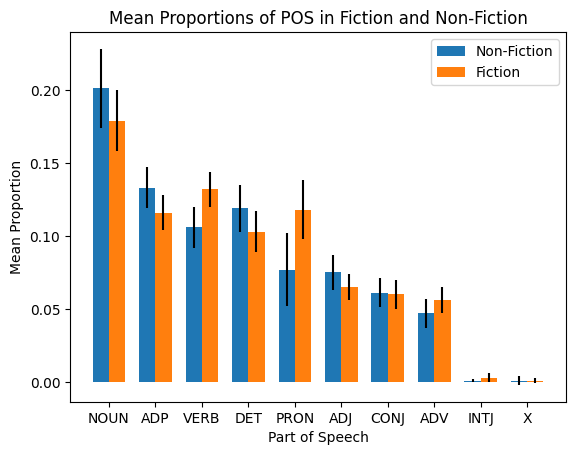

In [345]:
# Number of POS categories
n_pos = len(non_fiction_means)
ind = np.arange(n_pos)  # the x locations for the groups
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(ind - width/2, non_fiction_means, width, yerr=non_fiction_std, label='Non-Fiction')
rects2 = ax.bar(ind + width/2, fiction_means, width, yerr=fiction_std, label='Fiction')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Part of Speech')
ax.set_ylabel('Mean Proportion')
ax.set_title('Mean Proportions of POS in Fiction and Non-Fiction')
ax.set_xticks(ind)
ax.set_xticklabels(['NOUN', 'ADP', 'VERB', 'DET', 'PRON', 'ADJ', 'CONJ', 'ADV', 'INTJ', 'X'])
ax.legend()

# Attach a text label above each bar in rects1 and rects2, displaying its height and standard deviation
def autolabel(rects, stds):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect, std in zip(rects, stds):
        height = rect.get_height()

autolabel(rects1, non_fiction_std)
autolabel(rects2, fiction_std)

plt.show()

In non-fiction, there's a higher prevalence of nouns (Mean = 0.201, SD = 0.027) and adpositions (Mean = 0.133, SD = 0.014), potentially indicating a focus on detailed, factual descriptions. Conversely, fiction is characterized by a greater use of verbs (MEAN = 0.132, SD = 0.012) and pronouns (MEAN = 0.118, SD = 0.02), reflecting a narrative style centered on action and character development. Adjectives and adverbs show moderate usage across both genres, with slightly higher averages in non-fiction (MEAN = 0.075 SD = 0.012) and fiction (Mean =0.056, SD = 0.009) respectively. The standard deviations across these POS tags suggest a degree of variability within each genre, pointing to diverse authorial styles and narrative techniques. 

In [346]:
import matplotlib.pyplot as plt
import pandas as pd

# Your means and standard deviations (example values)
non_fiction_means = pd.Series(center_and_spread['Non-Fiction Mean'].tolist(), index=['NOUN', 'ADP', 'VERB', 'DET', 'PRON', 'ADJ', 'CONJ', 'ADV', 'INTJ', 'X'])
non_fiction_std = pd.Series(center_and_spread['Non-Fiction Std'].tolist(), index=['NOUN', 'ADP', 'VERB', 'DET', 'PRON', 'ADJ', 'CONJ', 'ADV', 'INTJ', 'X'])
fiction_means = pd.Series(center_and_spread['Fiction Mean'].tolist(), index=['NOUN', 'ADP', 'VERB', 'DET', 'PRON', 'ADJ', 'CONJ', 'ADV', 'INTJ', 'X'])
fiction_std = pd.Series(center_and_spread['Fiction Std'].tolist(), index=['NOUN', 'ADP', 'VERB', 'DET', 'PRON', 'ADJ', 'CONJ', 'ADV', 'INTJ', 'X'])

# Creating a DataFrame for easier plotting
data = {'POS': ['NOUN', 'ADP', 'VERB', 'DET', 'PRON', 'ADJ', 'CONJ', 'ADV', 'INTJ', 'X'] * 2,
        'Mean': center_and_spread['Non-Fiction Mean'].tolist() + center_and_spread['Fiction Mean'].tolist(),
        'Std': center_and_spread['Non-Fiction Std'].tolist() + center_and_spread['Fiction Std'].tolist(),
        'Genre': ['Non-Fiction'] * 10 + ['Fiction'] * 10}

df = pd.DataFrame(data)

In [347]:
# Combine the dataframes
df_combined = pd.concat([normalized_fiction_one_grams, normalized_nonfiction_one_grams])

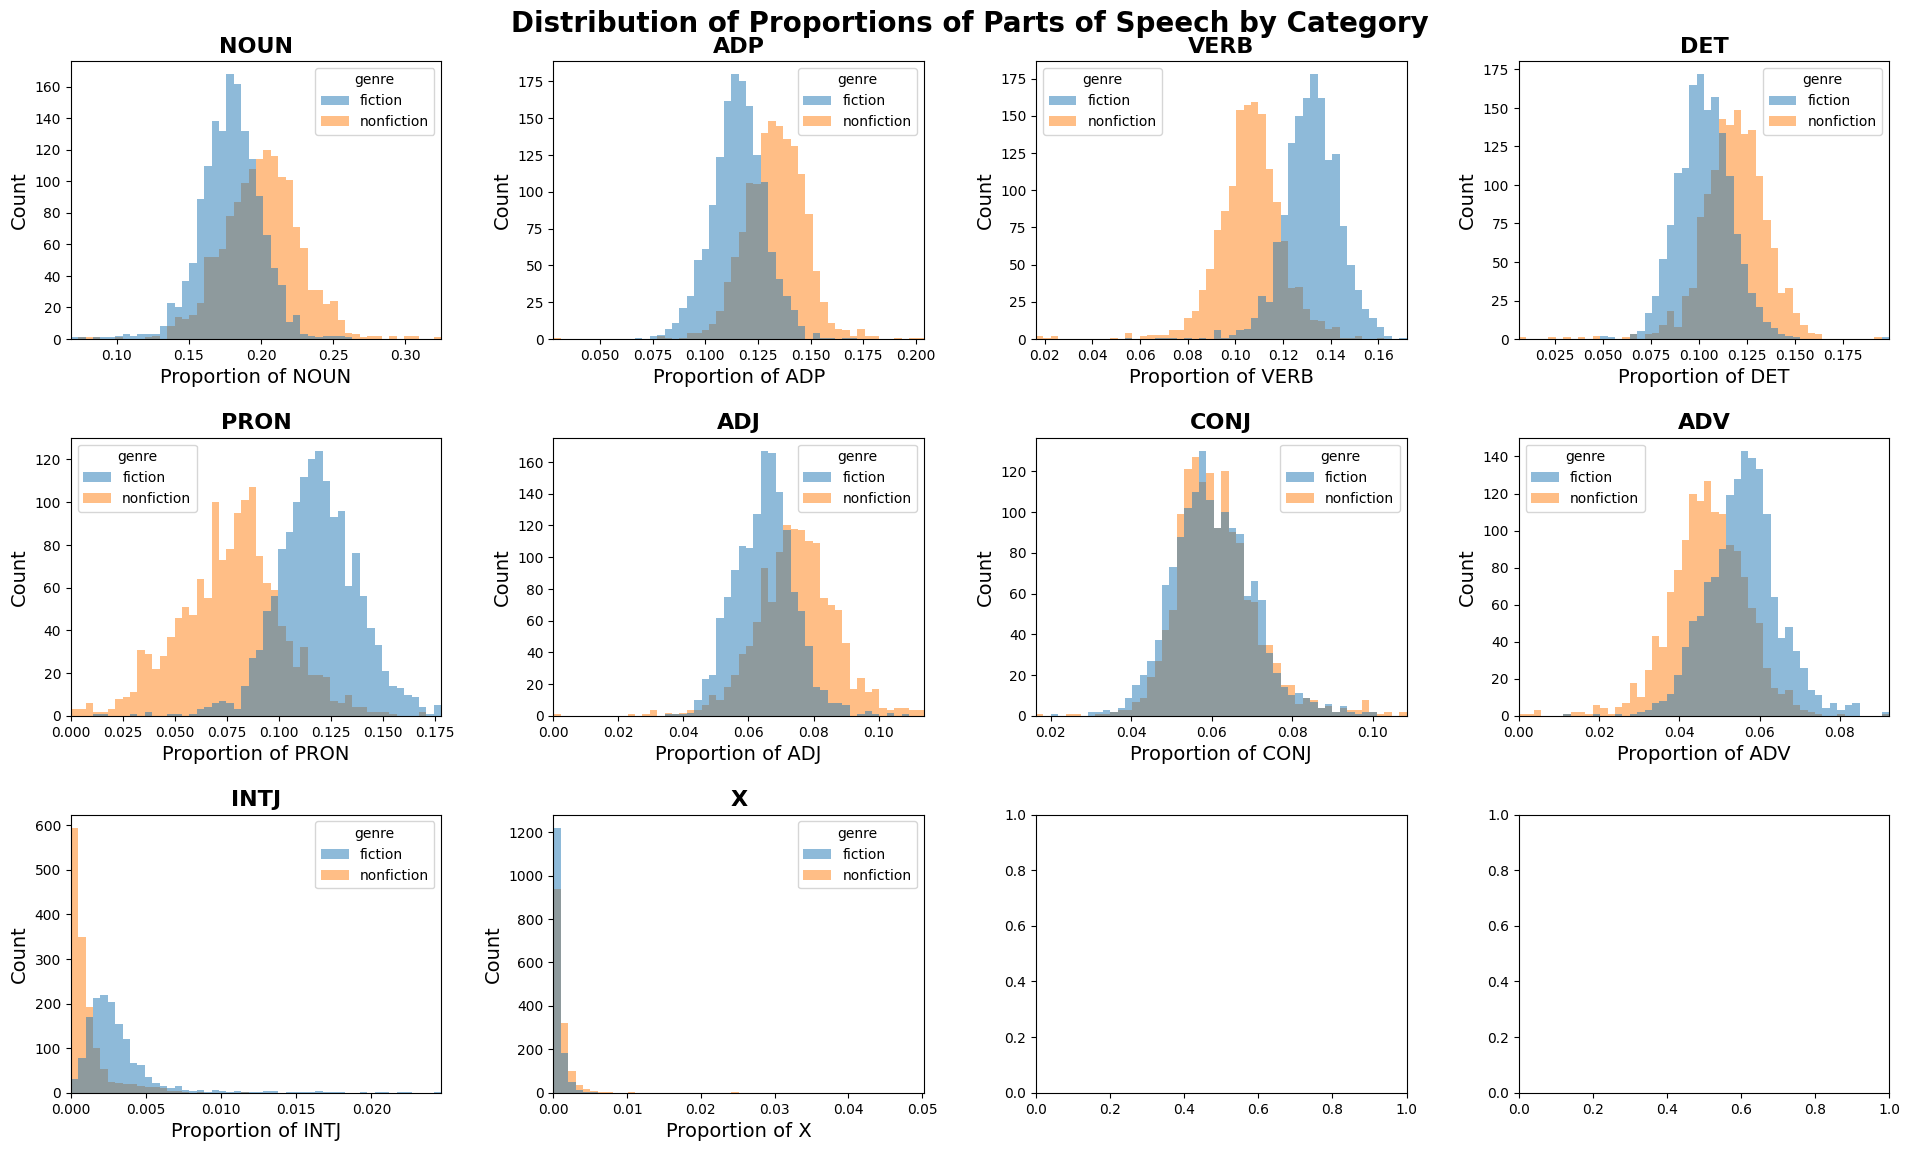

In [351]:
import matplotlib.pyplot as plt
import seaborn as sns

# Parts of speech
parts_of_speech = ['NOUN', 'ADP', 'VERB', 'DET', 'PRON', 'ADJ', 'CONJ', 'ADV', 'INTJ', 'X']

# Create a 2x4 subplot matrix
fig, axes = plt.subplots(3, 4, figsize=(20, 12))
fig.tight_layout(pad=5.0)

# Set a title for the whole plot
fig.suptitle('Distribution of Proportions of Parts of Speech by Category', fontsize=20, fontweight='bold')

# Loop over each part of speech and create a subplot
for i, pos in enumerate(parts_of_speech):
    ax = axes[i//4, i%4]  # Determine the position of the subplot
    sns.histplot(df_combined, x=f'{pos}', hue='genre', bins=50, ax=ax, edgecolor='none')
    ax.set_xlabel(f'Proportion of {pos}', fontsize=14)
    ax.set_ylabel('Count', fontsize=14)
    ax.set_title(f'{pos}', fontsize=16, fontweight='bold')
    # set x axis limits to be based on the max and min of the data
    ax.set_xlim(df_combined[f'{pos}'].min(), df_combined[f'{pos}'].max())


Most of the POS tag distributions for each genre are unimodal, but some like pronouns and interjections are heavily skewed. Although some like CONJ look roughly normal, it would not be fair to assume normally for all of these normalized counts. 

In [352]:
# Display side by side
display(HTML(desc_non_fiction._repr_html_() + "&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;" + desc_fiction._repr_html_()))

,NOUN,ADP,VERB,DET,PRON,ADJ,CONJ,ADV,INTJ,X
count,1477.000000,1477.000000,1477.000000,1477.000000,1477.000000,1477.000000,1477.000000,1477.000000,1477.000000,1477.000000
mean,0.178928,0.115605,0.132026,0.103002,0.118497,0.065016,0.060379,0.055859,0.003086,0.000743
std,0.021080,0.012492,0.011829,0.013917,0.019589,0.009115,0.010186,0.008981,0.002595,0.001537
min,0.068109,0.067302,0.055141,0.051500,0.010753,0.034373,0.020213,0.011609,0.000000,0.000000
25%,0.166359,0.107667,0.124959,0.093904,0.106237,0.058676,0.053540,0.050319,0.001707,0.000272
50%,0.178680,0.115739,0.132462,0.102599,0.118238,0.065310,0.059412,0.056224,0.002516,0.000534
75%,0.192047,0.123589,0.139928,0.112167,0.130546,0.070673,0.066778,0.061021,0.003596,0.000835
max,0.258199,0.170854,0.171862,0.198925,0.177922,0.107975,0.100820,0.091607,0.024653,0.034118
,NOUN,ADP,VERB,DET,PRON,ADJ,CONJ,ADV,INTJ,X
count,1435.000000,1435.000000,1435.000000,1435.000000,1435.000000,1435.000000,1435.000000,1435.000000,1435.000000,1435.000000


There appear to be notable differences in the distribution of POS tags between fiction and non-fiction texts. The distribution of pronouns and verbs appear to be the most different, while conjuntions appear to have the greatest amount of overlap.

In order to compare the POS tag distributions between fiction and non-fiction texts, the non-parametric Mann-Whitney U test was used. This statistical test is used to compare differences between two independent groups when the dependent variable is either ordinal or continuous. This non-parametric test was chosen because it does not assume normality and is robust to outliers so it appropriate as all of the POS tag distributions are not normally disitributed (determined by Shapiro-Wilk test). The Mann-Whitney U test was used to test the null hypothesis that the distributions of POS tags in fiction and non-fiction texts are the same. 

In [266]:
def check_normality(fiction_df, non_fiction_df, target_variable, alpha=0.05):
    """
    Compares the distributions of a target variable between fiction and non-fiction dataframes.

    :param fiction_df: DataFrame containing the fiction data.
    :param non_fiction_df: DataFrame containing the non-fiction data.
    :param target_variable: The name of the target variable column.
    :param alpha: Significance level for the statistical tests (default is 0.05).
    :return: None
    """

    # Normality Test with Shapiro-Wilk test
    stat_fiction, p_fiction = stats.shapiro(fiction_df[target_variable])
    stat_non_fiction, p_non_fiction = stats.shapiro(non_fiction_df[target_variable])

    # Check normality and choose appropriate test
    if p_fiction > alpha and p_non_fiction > alpha:
        print(f"Both groups are normally distributed for {target_variable}.")

In [267]:
parts_of_speech =  ['NOUN', 'ADP', 'VERB', 'DET', 'PRON', 'ADJ', 'CONJ', 'ADV', 'INTJ', 'X']

In [268]:
# Check normality for each part of speech - if there is no output then the data is not normally distributed
for pos in parts_of_speech:
    check_normality(normalized_fiction_one_grams, normalized_nonfiction_one_grams, f"{pos}")

In [269]:
def compare_distributions(normalized_fiction_df, normalized_non_fiction_df, target_variable, alpha=0.05):
    """
    Compares the distributions of a target variable between fiction and non-fiction dataframes.

    :param fiction_df: DataFrame containing the fiction data.
    :param non_fiction_df: DataFrame containing the non-fiction data.
    :param target_variable: The name of the target variable column.
    :param alpha: Significance level for the statistical tests (default is 0.05).
    :return: None
    """

    # Mann-Whitney U test
    t_stat, p_value = stats.mannwhitneyu(normalized_fiction_one_grams[target_variable], normalized_nonfiction_one_grams[target_variable])

    # Output the test statistic and p-value
    return t_stat, p_value

In [781]:
# Compare distributions for each part of speech

# Create an empty dictionary to store the results
results_dict = {}

for pos in parts_of_speech:
    t_stat, p_value = compare_distributions(normalized_fiction_one_grams, normalized_nonfiction_one_grams, f"{pos}")

    # Save each new results to a dictionary
    results_dict[pos] = {'t_stat': t_stat, 'p_value': p_value}

In [782]:
# Create a DataFrame from the results dictionary
results_df = pd.DataFrame(results_dict).T

# Check if any of the p values are greater than 0.05 after dividing by the number of tests - Bonferroni Correction
results_df['p_value'] = results_df['p_value'] / len(parts_of_speech)

# Display the DataFrame
results_df

,t_stat,p_value
NOUN,535042.0,2.189789e-119
ADP,349630.0,3.810075e-216
VERB,1977073.5,0.000000e+00
DET,454881.0,1.157112e-157
PRON,1930950.0,0.000000e+00
ADJ,530187.0,1.500301e-121
CONJ,1019866.5,7.871589e-03
ADV,1602051.0,2.519005e-127
INTJ,1815660.5,1.648405e-244
X,859983.5,1.285926e-19


All of the POS tags were found to be significantly different between fiction and non-fiction texts. The p-values for all of the POS tags were less than 0.05, indicating that the null hypothesis can be rejected. 

Since we are working with a large sample size, the Mann-Whitney U test is expected to be significant even for small differences (Andrade et al.). Therefore, the effect size of the differences between the POS tag distributions in fiction and non-fiction texts was calculated using Cliff's Delta. Cliff's Delta is a non-parametric effect size measure that quantifies the difference between two groups. It is calculated by subtracting the probability that a randomly selected value from one group is greater than a randomly selected value from the other group from the probability that a randomly selected value from one group is less than a randomly selected value from the other group. The resulting value ranges from -1 to 1, with 0 indicating no difference, -1 indicating that all values in the first group are less than all values in the second group, and 1 indicating that all values in the first group are greater than all values in the second group.

In [451]:
def cliffs_delta(group1, group2):
    """
    Calculate Cliff's Delta for measuring effect size.
    
    :param group1: First group of data.
    :param group2: Second group of data.
    :return: Cliff's Delta value.
    """
    n1, n2 = len(group1), len(group2)
    n = n1 * n2
    more = sum(x > y for x in group1 for y in group2)
    equal = sum(x == y for x in group1 for y in group2)
    delta = (more - (n - equal - more)) / n
    return delta

In [452]:
# Calculate Cliff's Delta for each part of speech

# Create an empty dictionary to store the results
cliffs_delta_dict = {}

for pos in parts_of_speech:
    delta = cliffs_delta(normalized_fiction_one_grams[f"{pos}"], normalized_nonfiction_one_grams[f"{pos}"])
    
    # Save each new results to a dictionary
    cliffs_delta_dict[pos] = delta


The table below shows the effect size of the differences between the POS tag distributions in fiction and non-fiction texts.

In [273]:
# Display the results in a table 
cliffs_delta_df = pd.DataFrame(cliffs_delta_dict, index=['Cliff\'s Delta']).T

# Display the DataFrame
cliffs_delta_df


,Cliff's Delta
NOUN,-0.495123
ADP,-0.670082
VERB,0.865608
DET,-0.570765
PRON,0.822085
ADJ,-0.499704
CONJ,-0.037633
ADV,0.511729
INTJ,0.713295
X,-0.188502


Cliff's Delta is a measure of effect size, which quantifies the amount of difference between two groups of data. In this context, the values represent the magnitude and direction of differences in the usage of various parts of speech (POS) between fiction and non-fiction texts. For adjectives (ADJ), a Cliff's Delta value of -0.499704 indicates a medium to large negative effect size, suggesting that adjectives are more prevalent in non-fiction than in fiction. Conversely, the positive value for adverbs (ADV) at 0.511729 implies a higher frequency in fiction. Nouns (NOUN) exhibited a medium negative effect size (-0.495123), indicating they are more common in non-fiction texts. Verbs (VERB) showed a large positive effect size (0.865608), strongly suggesting their greater frequency in fiction.

The value for adpositions (ADP) was -0.670082, a large negative effect size, indicating a more significant presence in non-fiction. Interjections (INTJ), with a value of 0.713295, displayed a large positive effect size, indicating a notably higher occurrence in fiction. Pronouns (PRON) also showed a large positive effect size (0.822085), suggesting their frequent use in fiction compared to non-fiction. The difference in Conjunctions (CONJ) was not very pronounced.

These findings highlight distinct linguistic patterns across genres, with certain POS tags like verbs, interjections, and pronouns being more dominant in fiction, while adjectives, nouns, and adpositions are more prevalent in non-fiction. 

In [464]:
## 2 - Gram
two_gram_POS_tags = normalized_fiction_two_grams.columns[3:-2]

normalized_fiction_two_grams

# Create an empty dictionary to store the results
cliffs_delta_dict = {}

for pos in two_gram_POS_tags:
    delta = cliffs_delta(normalized_fiction_two_grams[f"{pos}"], normalized_nonfiction_two_grams[f"{pos}"])
    
    # Save each new results to a dictionary
    cliffs_delta_dict[pos] = delta

In [468]:
# Display the results in a table 
cliffs_delta_df = pd.DataFrame(cliffs_delta_dict, index=['Cliff\'s Delta']).T

# Display the DataFrame, sort by absolute value of Cliff's Delta 
cliffs_delta_df['abs_delta'] = cliffs_delta_df['Cliff\'s Delta'].abs()
cliffs_delta_df.sort_values(by='abs_delta', ascending=False).head(20)

,Cliff's Delta,abs_delta
VERB_PRON,0.849875,0.849875
PRON_VERB,0.847168,0.847168
VERB_ADV,0.790731,0.790731
ADV_PRON,0.770963,0.770963
INTJ_PRON,0.749454,0.749454
PRON_PRON,0.732801,0.732801
NOUN_ADP,-0.711508,0.711508
PRON_INTJ,0.707871,0.707871
ADP_ADJ,-0.699542,0.699542
NOUN_INTJ,0.693989,0.693989


# Classification

In [749]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV

MODELING_RANDOM_SEED = 87

## One Gram 

In [750]:
# sort the rows of combined_df to be in the same order as combined_one_grams 
combined_one_grams = combined_one_grams.sort_values(by=['cleaned_text', 'genre']).reset_index(drop=True)

In [751]:
# Build a logistic regression model using unigrams
X = combined_one_grams.drop(['genre', 'cleaned_text'], axis=1)
y = combined_one_grams['genre']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=MODELING_RANDOM_SEED)


In [752]:
#### Define the Pipelines  ####  

# Logistic Regression Pipeline
pipe_lr = Pipeline([
    ('classifier', LogisticRegression())
])

In [753]:
#### Define the parameters for the GridSearchCV ####  

# For Logistic Regression
params_lr = {
    'classifier__C': [0.1, 1, 10] # Regularization parameter 
}

# Logistic Regression Grid Search
grid_search_lr = GridSearchCV(pipe_lr, param_grid=params_lr, cv=5, verbose=1, n_jobs=-1, scoring = 'f1_weighted')

In [754]:
# Fitting logistic regression models 
grid_search_lr.fit(X_train, y_train)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('classifier', LogisticRegression())]),
             n_jobs=-1, param_grid={'classifier__C': [0.1, 1, 10]},
             scoring='f1_weighted', verbose=1)

In [755]:
# Check best parameters and scores
print("Best LR Params: ", grid_search_lr.best_params_)
print("Best LR Score: ", grid_search_lr.best_score_)

Best LR Params:  {'classifier__C': 10}
Best LR Score:  0.8732587383613835


In [756]:
# Train the best models on the full training set
best_lr_model = grid_search_lr.best_estimator_
best_lr_model.fit(X_train, y_train)

Pipeline(steps=[('classifier', LogisticRegression(C=10))])

In [757]:
# Predictions
y_pred_lr = grid_search_lr.predict(X_test)

# Classification Report
print(classification_report(y_test, y_pred_lr))

              precision    recall  f1-score   support

     fiction       0.87      0.91      0.89       295
  nonfiction       0.91      0.86      0.88       288

    accuracy                           0.89       583
   macro avg       0.89      0.89      0.89       583
weighted avg       0.89      0.89      0.89       583



In [758]:
coef_df = pd.DataFrame({'coefficients':list(best_lr_model.named_steps['classifier'].coef_.flatten()), 'POS': list(combined_one_grams.drop(['genre',  'cleaned_text' ], axis=1).columns)})

In [759]:
# take the lowest coefficients
lowest = coef_df.sort_values(by='coefficients').head(20).reset_index(drop=True)
lowest.columns = [col+'_1' for col in lowest.columns]

# take the highest coefficients
highest = coef_df.sort_values(by='coefficients').tail(20).sort_values(by='coefficients', ascending=False).reset_index(drop=True)
highest.columns = [col+'_2' for col in highest.columns]

# put them together to compare
pd.concat([lowest, highest], axis=1)

,coefficients_1,POS_1,coefficients_2,POS_2
0,-32.869273,VERB,14.742141,ADP
1,-32.341407,PRON,10.897152,CONJ
2,-7.441697,ADV,7.488658,ADJ
3,-1.967774,INTJ,6.141487,DET
4,0.323940,X,3.376460,NOUN
5,3.376460,NOUN,0.323940,X
6,6.141487,DET,-1.967774,INTJ
7,7.488658,ADJ,-7.441697,ADV
8,10.897152,CONJ,-32.341407,PRON
9,14.742141,ADP,-32.869273,VERB


In [760]:
from functools import reduce

## All Four POS Tag Sequences Used As Features 

In [767]:

data_frames = [combined_one_grams, combined_two_grams, combined_three_grams, combined_four_grams]
combined_df = reduce(lambda left, right: pd.merge(left, right, on=['cleaned_text', 'genre'], how='outer'), data_frames)

In [768]:
# sort the rows of combined_df to be in the same order as combined_one_grams 
combined_df = combined_df.sort_values(by=['cleaned_text', 'genre']).reset_index(drop=True)

In [769]:
combined_df["genre"].value_counts()

genre
fiction       1477
nonfiction    1435
Name: count, dtype: int64

In [770]:
combined_one_grams["genre"].value_counts()

genre
fiction       1477
nonfiction    1435
Name: count, dtype: int64

In [771]:
#### Test/Train Split  ####  

# Define the features and target variable
X = combined_df.drop(['genre', 'cleaned_text'], axis=1)
y = combined_df['genre']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=MODELING_RANDOM_SEED)

In [772]:
y_test.value_counts()

genre
fiction       295
nonfiction    288
Name: count, dtype: int64

In [773]:
#### Define the parameters for the GridSearchCV ####  

# For Logistic Regression
params_lr = {
    'classifier__C': [0.1, 1, 10] # Regularization parameter 
}

# Logistic Regression Grid Search
grid_search_lr = GridSearchCV(pipe_lr, param_grid=params_lr, cv=5, verbose=1, n_jobs=-1, scoring = 'f1_weighted')

In [774]:
# Fitting logistic regression models 
grid_search_lr.fit(X_train, y_train)


Fitting 5 folds for each of 3 candidates, totalling 15 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('classifier', LogisticRegression())]),
             n_jobs=-1, param_grid={'classifier__C': [0.1, 1, 10]},
             scoring='f1_weighted', verbose=1)

In [775]:
# Check best parameters and scores
print("Best LR Params: ", grid_search_lr.best_params_)
print("Best LR Score: ", grid_search_lr.best_score_)

Best LR Params:  {'classifier__C': 10}
Best LR Score:  0.8835652986203515


In [776]:
# Train the best models on the full training set
best_lr_model = grid_search_lr.best_estimator_
best_lr_model.fit(X_train, y_train)

Pipeline(steps=[('classifier', LogisticRegression(C=10))])

In [777]:
# Predictions
y_pred_nb = grid_search_lr.predict(X_test)

# Classification Report
print(classification_report(y_test, y_pred_nb))

              precision    recall  f1-score   support

     fiction       0.88      0.92      0.90       295
  nonfiction       0.92      0.87      0.89       288

    accuracy                           0.90       583
   macro avg       0.90      0.90      0.90       583
weighted avg       0.90      0.90      0.90       583



In [778]:
coef_df = pd.DataFrame({'coefficients':list(best_lr_model.named_steps['classifier'].coef_.flatten()), 'POS': list(combined_df.drop(['genre',  'cleaned_text' ], axis=1).columns)})

In [779]:
# take the lowest coefficients
lowest = coef_df.sort_values(by='coefficients').head(20).reset_index(drop=True)
lowest.columns = [col+'_1' for col in lowest.columns]

# take the highest coefficients
highest = coef_df.sort_values(by='coefficients').tail(20).sort_values(by='coefficients', ascending=False).reset_index(drop=True)
highest.columns = [col+'_2' for col in highest.columns]

# put them together to compare
pd.concat([lowest, highest], axis=1)

,coefficients_1,POS_1,coefficients_2,POS_2
0,-26.694859,VERB,11.936385,ADP
1,-25.313511,PRON,9.941648,CONJ
2,-10.285300,PRON_VERB,8.907567,NOUN_ADP
3,-8.707383,VERB_PRON,5.524043,ADP_NOUN
4,-8.387785,NOUN_VERB,4.864333,ADJ
5,-7.502559,PRON_NOUN,4.609249,DET
6,-6.450786,ADV,4.314780,NOUN_CONJ
7,-5.391115,VERB_ADV,3.326717,CONJ_NOUN
8,-5.150747,ADP_PRON,3.162826,ADJ_NOUN
9,-4.292402,DET_NOUN,3.131499,NOUN_ADP_NOUN
